In [692]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [693]:
# transformation: array -> binary form
def to_one_hot(Y):
    n_col = np.amax(Y) + 1  # max_value + 1
    binarized = np.zeros((len(Y), n_col))  # arr: [[0., ..., * <len n_col>],..., * <len Y>]

    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.

    return binarized

# y = np.array([1, 2, 3, 6, 3])
# print(to_one_hot(y))

# output [5 x 7] <[len(y), n_col]:
# [[0. 1. 0. 0. 0. 0. 0.]  | 1
#  [0. 0. 1. 0. 0. 0. 0.]  | 2
#  [0. 0. 0. 1. 0. 0. 0.]  | 3
#  [0. 0. 0. 0. 0. 0. 1.]  | 6
#  [0. 0. 0. 1. 0. 0. 0.]] | 3

In [694]:
# transformation: in normal form
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))  # [[0.], [0.] ...]

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if l[j] == 1:
                arr[i] = j + 1

    return arr

# y = np.array([1, 2, 3, 6, 3])
# layer = np.array([[0, 1, 0], [0, 0, 0], [0, 1, 0], [1, 0, 0],[0, 0, 1]])
#
# print(from_one_hot(y, layer))

# output index+1 where value = 1:
# [[2.]
#  [0.]
#  [2.]
#  [1.]
#  [3.]]

In [695]:
# sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

def ReLU(x):
    return x * (x > 0)

def ReLU_derivative(x):
    return x > 0

# normalization
def normalize(X, axis=-1, order=2):
    # L2 = sqrt(x**2+y**2...) <Euclidean norm>
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))  # L2 to every row => L2 length vector 1, e.g. 3.5 => length 1
    l2[l2 == 0] = 1  # if norm == 0 => norm = 1

    return X / np.expand_dims(l2, axis)  # [[v1, v2]] / [[L2]] => e.g. v1 / 3.5, i.e. proportion

In [696]:
# import iris
from sklearn.datasets import load_iris

# dataset
iris = load_iris()

# info
# print(iris.DESCR)

# convert dataset to pandas
iris_data = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# target
iris_data["Species"] = [iris.target_names[i] for i in iris.target]

# present examples
np.random.seed(42)
iris_data.sample(n=5)  # random samples

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
73,6.1,2.8,4.7,1.2,versicolor
18,5.7,3.8,1.7,0.3,setosa
118,7.7,2.6,6.9,2.3,virginica
78,6.0,2.9,4.5,1.5,versicolor
76,6.8,2.8,4.8,1.4,versicolor


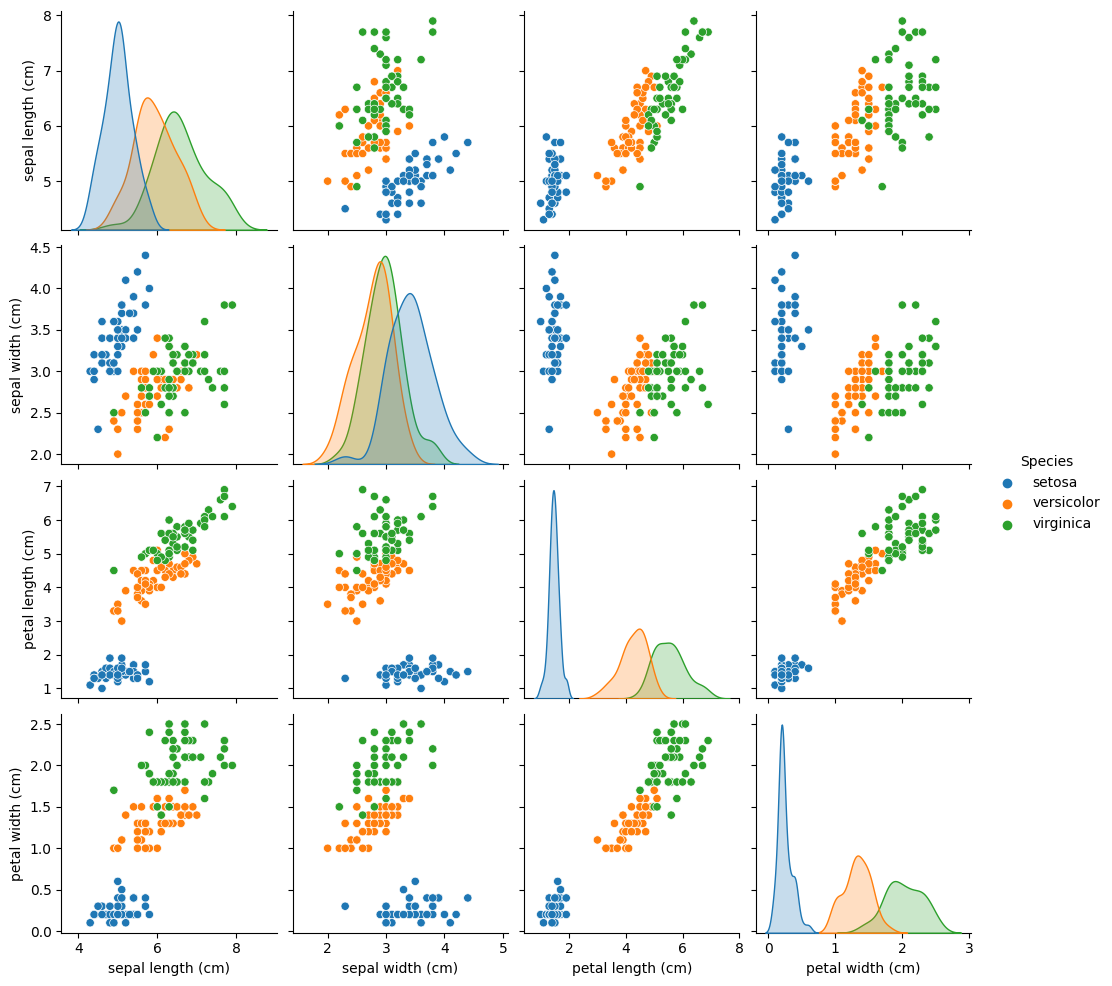

In [697]:
# representation
g = sns.pairplot(iris_data, hue="Species")
plt.show()

In [698]:
# convert names to class numbers
#iris_data["Species"] = pd.factorize(iris_data['Species'])[0]
iris_data['Species'].replace(['setosa', 'virginica', 'versicolor'], [0, 1, 2], inplace=True)

# show changes (Species)
np.random.seed(42)
iris_data.sample(n=5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
73,6.1,2.8,4.7,1.2,2
18,5.7,3.8,1.7,0.3,0
118,7.7,2.6,6.9,2.3,1
78,6.0,2.9,4.5,1.5,2
76,6.8,2.8,4.8,1.4,2


In [699]:
# formation X
X = normalize(iris_data.iloc[:, :-1].values)

# formation y
y = iris_data.iloc[:, -1:].values
y = y.flatten()
y = to_one_hot(y)

# show np arrays <normalize X, y>
np.random.seed(42)
rand_ind = np.random.choice(len(X), size=5, replace=False)

print(X[rand_ind])
print(y[rand_ind])

[[0.73659895 0.33811099 0.56754345 0.14490471]
 [0.8068282  0.53788547 0.24063297 0.04246464]
 [0.70600618 0.2383917  0.63265489 0.21088496]
 [0.73350949 0.35452959 0.55013212 0.18337737]
 [0.76467269 0.31486523 0.53976896 0.15743261]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### Learning functions

In [700]:
# errors chart
def errors_chart(errors, accuracy):
    plt.figure(figsize=(3, 2))
    plt.plot(errors)
    plt.xlabel("learning")
    plt.ylabel("Error")
    plt.show()
    print(f"Accuracy: {round(accuracy, 2)}%")


# random weights => number layers
def random_weights(sizes_layers=[5], bias=1):

    # [first, hidden, last]
    sizes = [4, *sizes_layers, 3]

    # random weights
    weights_arr = []

    for i in range(len(sizes) - 1):
        weights_arr.append(2 * np.random.random((sizes[i], sizes[i+1])) - bias)

    return np.array(weights_arr, dtype=object)


# learning
def learning(iters=1000, learning_rate=0.05, weights=random_weights([5]), test_size=0.33):

    # train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    accuracy = 0

    # learning rate
    n = learning_rate
    errors = []

    for i in range(iters):
        layer = X_train
        layers = [layer]

        # activate
        for j in range(len(weights)):
            layer = sigmoid(np.dot(layer, weights[j]))
            layers.append(layer)

        # errors calculation
        layer_error = y_train - layer
        error = np.mean(np.abs(layer_error))
        errors.append(error)

        # redistribution of weights
        for j in range(len(layers)-1, 0, -1):
            layer_delta = layer_error * sigmoid_derivative(layers[j])
            layer_error = layer_delta.dot(weights[j-1].T)

            weights[j - 1] += layers[j - 1].T.dot(layer_delta) * n

        accuracy = (1 - error) * 100

    # show result
    errors_chart(errors, accuracy)

    return

### Calculations

#### 0) default learning iters=1000, learning_rate=0.05, weights=\<hidden layers sizes\>[5], test_size=0.33

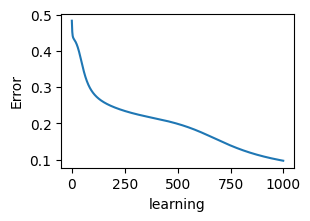

Accuracy: 90.28%


In [701]:
learning()

#### 1) iterations changing

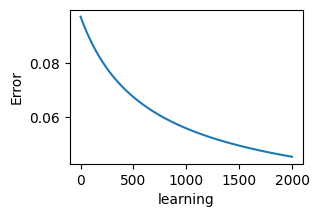

Accuracy: 95.45%


In [702]:
learning(iters=2000)

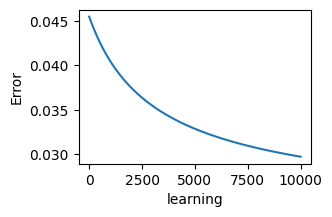

Accuracy: 97.03%


In [703]:
learning(iters=10000)

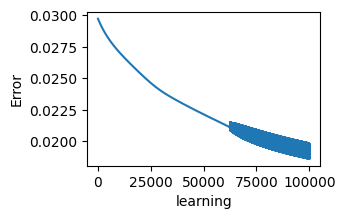

Accuracy: 98.14%


In [704]:
learning(iters=100000)

#### 2) changing neurons of hide layer

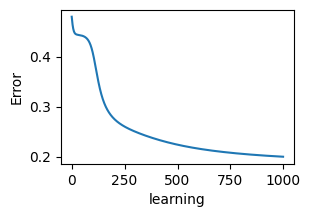

Accuracy: 80.0%


In [705]:
learning(weights=random_weights([2]))

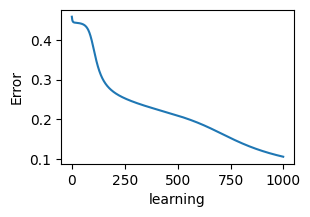

Accuracy: 89.48%


In [706]:
learning(weights=random_weights([3]))

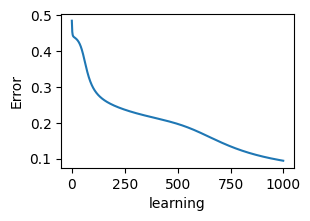

Accuracy: 90.57%


In [707]:
learning(weights=random_weights([5]))

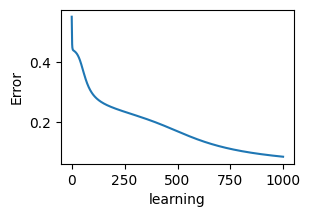

Accuracy: 91.59%


In [708]:
learning(weights=random_weights([7]))

#### 3) changing learning rate

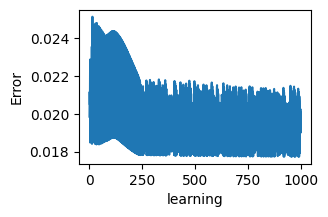

Accuracy: 97.98%


In [709]:
learning(learning_rate=0.1)

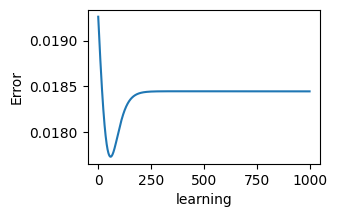

Accuracy: 98.16%


In [710]:
learning(learning_rate=0.001)

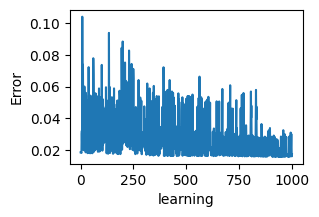

Accuracy: 98.28%


In [711]:
learning(learning_rate=0.5)

#### 4) changing test size

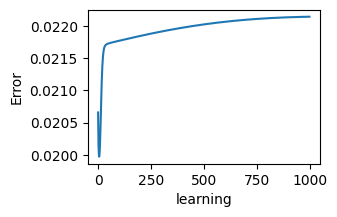

Accuracy: 97.79%


In [712]:
learning(test_size=0.5)

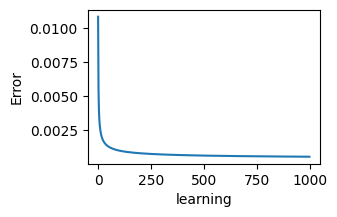

Accuracy: 99.94%


In [713]:
learning(test_size=0.8)

#### 5) changing bias

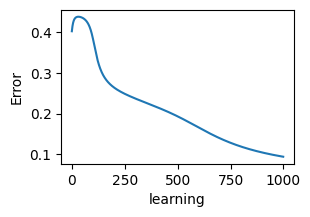

Accuracy: 90.59%


In [714]:
learning(weights=random_weights(bias=2))

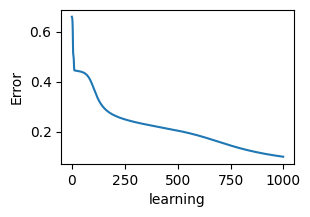

Accuracy: 90.0%


In [715]:
learning(weights=random_weights(bias=0.1))

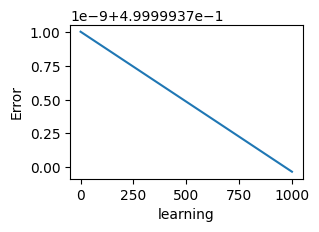

Accuracy: 50.0%


In [716]:
learning(weights=random_weights(bias=10))

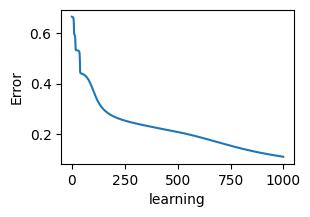

Accuracy: 88.9%


In [717]:
learning(weights=random_weights(bias=0))

#### 6) changing number layers & size layers

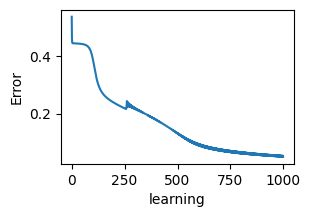

Accuracy: 94.91%


In [718]:
learning(weights=random_weights([7, 8]))

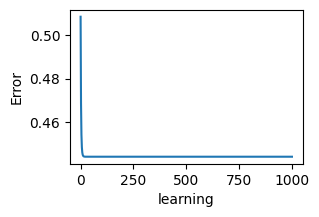

Accuracy: 55.61%


In [719]:
learning(weights=random_weights([7, 8, 3, 4, 5, 6]))

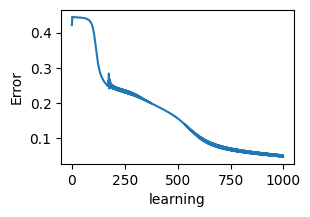

Accuracy: 95.23%


In [720]:
learning(weights=random_weights([8, 4, 17]))

### Best model (test_size=default)

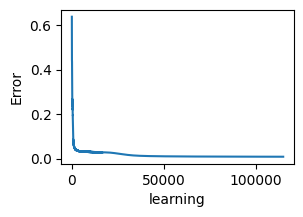

Accuracy: 99.17%


In [721]:
learning(iters=115000, learning_rate=0.05, weights=random_weights([5, 6], bias=1/3))

## Conclusion:

Улучшение наблюдаются при увеличении количества итераций (эпох).

Нетрудно догадаться, что размер тестового датасета напрямую влияет на результат. Поэтому сбор данных - ключ к хорошим прогнозам.

Шаг обучения достаточно чувствительный параметр, который может сильно влиять на выходные данные. Большое значение не будет давать
точного приближения к истинному результату, но может ускорить этот процесс на начальных этапах, как вариант, сделать его адаптивным
(например при увеличении количества эпох постепенно понижать значение). И наоборот, если шаг обучения выставить слишком маленьким,
то мы затратим больше времени на обучение, т.е. придется увеличивать количество итераций, чтобы достичь удовлетворительного результата.

Размер скрытого слоя выбирается по общим рекомендациям. Например, иметь скрытый слой с размером, который превышает количество признаков.
Это позволяет сети выучить более сложные зависимости и извлекать более информативные признаки. Или хорошей практикой является
иметь размер скрытого слоя, превышающий количество классов. Здесь мы имеем более творческий подход, что дает возможность эксперементировать.

Но при большом размере скрытого слоя мы резко теряем в точности (модель подвергается переобучению), это связано
с небольшим размером датасета (тем более train предоставляет еще меньше данных).
Так же для 4 признаков большой скрытый слой будет избыточен.

Ради эксперимента, я модернизировал модель обучения и сделал ее более универсальной, чтобы можно было работать
с несколькими скрытыми слоями. Дополнительные скрытые слои могут дать преимущество. Хотя модель становится сложнее для обучения.

Еще можно повлиять на результаты заменив функцию активации и ее производной на другие подобные функции.
<br>

#### Итог:
  Ухудшают точность:
  маленький датасет и малое число признаков, большой шаг обучения, как и очень маленький,
  малое число эпох, большое количество скрытых слоев, большой или очень маленький размер скрытого слоя,
  неверный выбор функции активации (в зависимости от задачи).

  Улучшают точность:
  большой датасет и достаточное число признаков, адаптивный шаг обучения, достаточное число эпох
  (но не запредельное), количество скрытых слоев под выбранную задачу, средний размер скрытых слоев, функция активации,
  которая соответствует решаемым задачам.
